# Etude de la détection automatique de caractéristiques sur un signal audio
![ISEN Lille](src/imgs/isen.jpg)

| Référents ||| Projet M1 réalisé par ||
|-|-|-|-|-|
| A. Frappé | A. Gonzalez | B. Larras | J. Le Bellego | S. Lecoq |

# > Mise en place

Ce rapport est un notebook [Jupyter](http://jupyter.org/).

Les cellules contenant du **code** peuvent être exécutées en appuyant sur simultanément sur les touches *Maj + Entrée*.

#### Initialisation et dépendances 

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%matplotlib notebook
%run -i bin/imports.py

In [2]:
%%html
<script>
IPython.OutputArea.prototype._should_scroll = lines => { return false }  
</script>
<style>
.output_wrapper button.btn.btn-default, .output_wrapper .ui-dialog-titlebar { display: none; }
.output_stderr { display: none; }
.ui-resizable { pointer-events:none; }
</style>

# > A propos

Le but de ce projet est d'extraire les caractéristiques d'un signal audio en utilisant le moins de ressources possible dans le but de réaliser des circuits très économes. Cela revient à limiter la résolution du convertisseur analogique numérique, réduire le nombre de filtres de la banque de filtres ainsi que leurs coefficients de qualité et ordre, déterminer la résolution temporelle et d'amplitude optimums pour la quantification d'énergie tout en mettant en exergue les *Audio features* d'un signal audio.

Ci-dessous se trouve la chaîne complète du système simulé dans ce projet.

![Chaîne de l'extraction d'audio features](src/imgs/chain.png)

# > Récupération du signal d'entrée

La bibliothèque de gestion des fichiers audios utilisée est **scipy.io.wavfile**. Il est conseillé d'utiliser un fichier **.wav** (audio mono 16 bits).

Un fichier audio, outre ses méta-données, contient la fréquence d'échantillonage (que nous noterons **fs**) ainsi qu'une liste de différentes amplitudes qui représentent le signal (que nous noterons **y**).

A partir de là, nous noterons **N** le nombre d'échantillons du signal et **t** les points temporels qui les caractérise.

In [3]:
# Lecture du fichier audio
fs, y = sw.read("src/demo.wav")
# Nombre d'échantillons et échelle temporelle
N = len(y)
t = np.linspace(0, N/fs, N)

# Lecteur audio
ipd.Audio(data=y, rate=fs)

Dans la suite de ce rapport, nous supposerons que le signal d'entrée *(i.e. le fichier de démonstration actuellement utilisé)* est encore un signal analogique, jusqu'à l'étape de numérisation.

### Spectre d'amplitude

La fonction [**plot_specamp**](https://github.com/lowlighter/sound/blob/master/bin/plot_specamp.py) permet de visualiser le spectre d'amplitude du signal audio, c'est-à-dire les différentes impulsions du signal (en ordonnée) en fonction du temps (en abscisse).

Notez que l'amplitude est normalisée par rapport à l'amplitude maximale du signal.

<IPython.core.display.Javascript object>


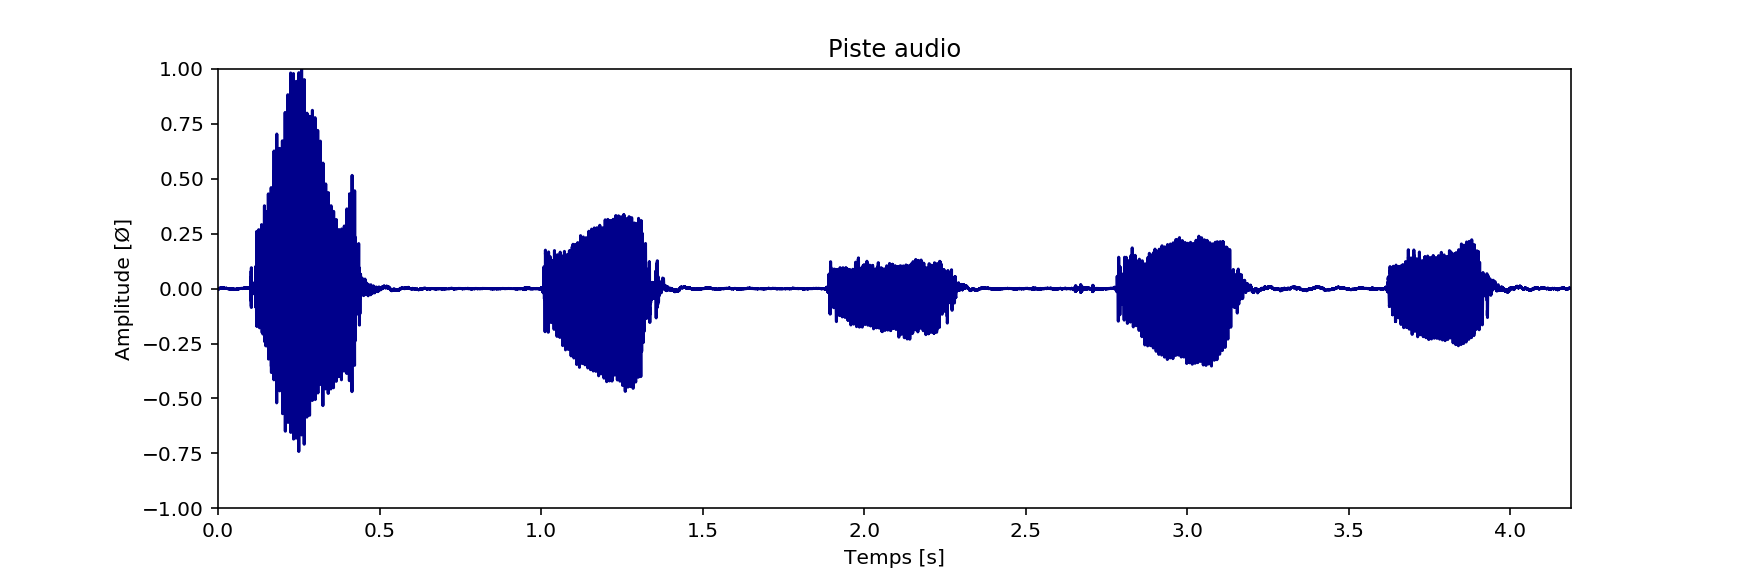

In [4]:
%run -i bin/plot_specamp.py
plot_specamp(y/max(abs(y)), t)

#### Spectre en dB Full Scale

Il est important de garder à l'esprit que le format **.wav** utilise une échelle nommée le **dB FS** pour quantifier le niveau sonore. Pour calculer cette valeur, il suffit d'utiliser la relation suivante :

$$y_{(dB FS)} = 20 \cdot log_{10}(\frac{|y|}{2^{n-1}})$$

Il s'agit d'une échelle relative et n'est pas forcément représentative du niveau sonore avant numérisation. 
Le niveau en dB FS est toujours négatif.

La fonction [**plot_dbfs**](https://github.com/lowlighter/sound/blob/master/bin/plot_dbfs.py) permet de visualiser le spectre dB Full Scale.

<IPython.core.display.Javascript object>


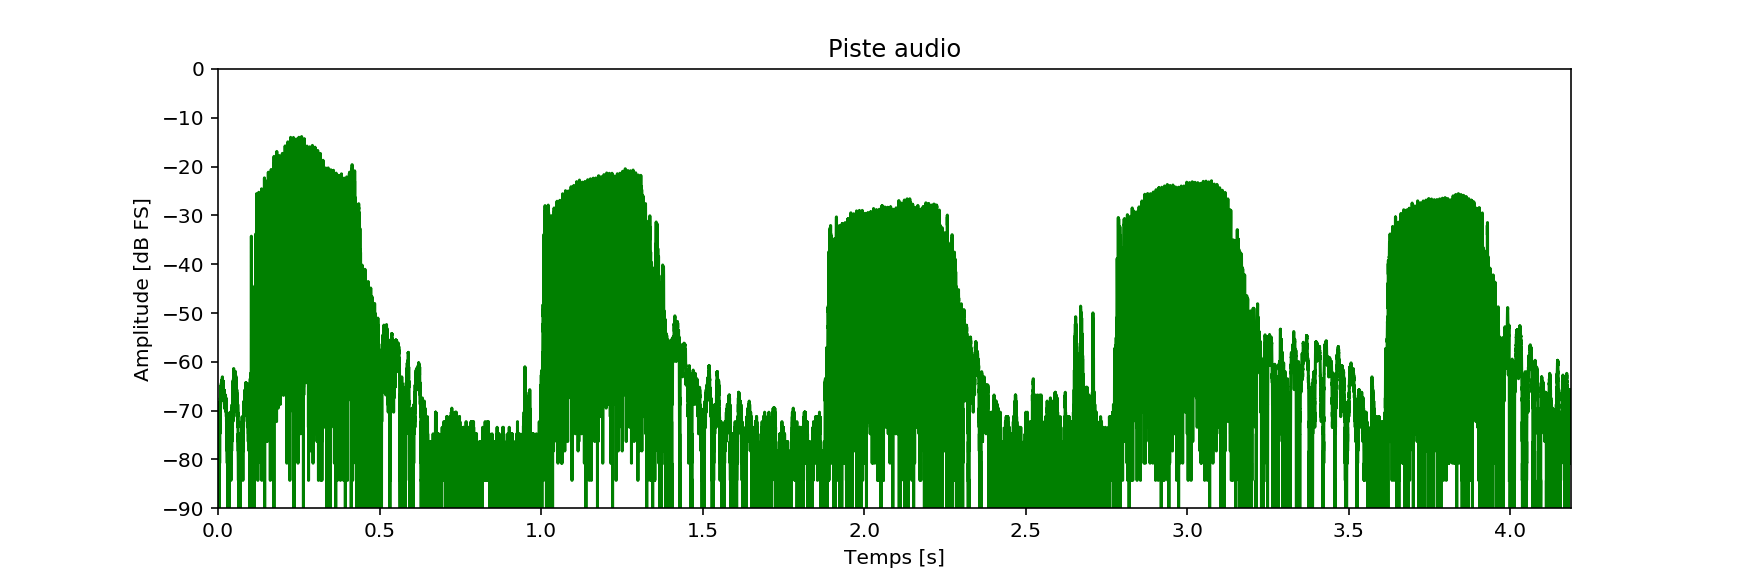

bin/plot_dbfs.py:18: RuntimeWarning: divide by zero encountered in log10
  ax.plot(t, 20*np.log10(abs(np.array(y))/32767), color=color)


In [5]:
%run -i bin/plot_dbfs.py
plot_dbfs(y, t)

#### Spectrogramme

La fonction [**plot_specgram**](https://github.com/lowlighter/sound/blob/master/bin/plot_specgram.py) permet de visualiser le spectrogramme du signal audio, qui représente la densité spectrale de puissance (en nuances de couleurs) par fréquence (en ordonnée) selon le temps (en abscisse).

<IPython.core.display.Javascript object>


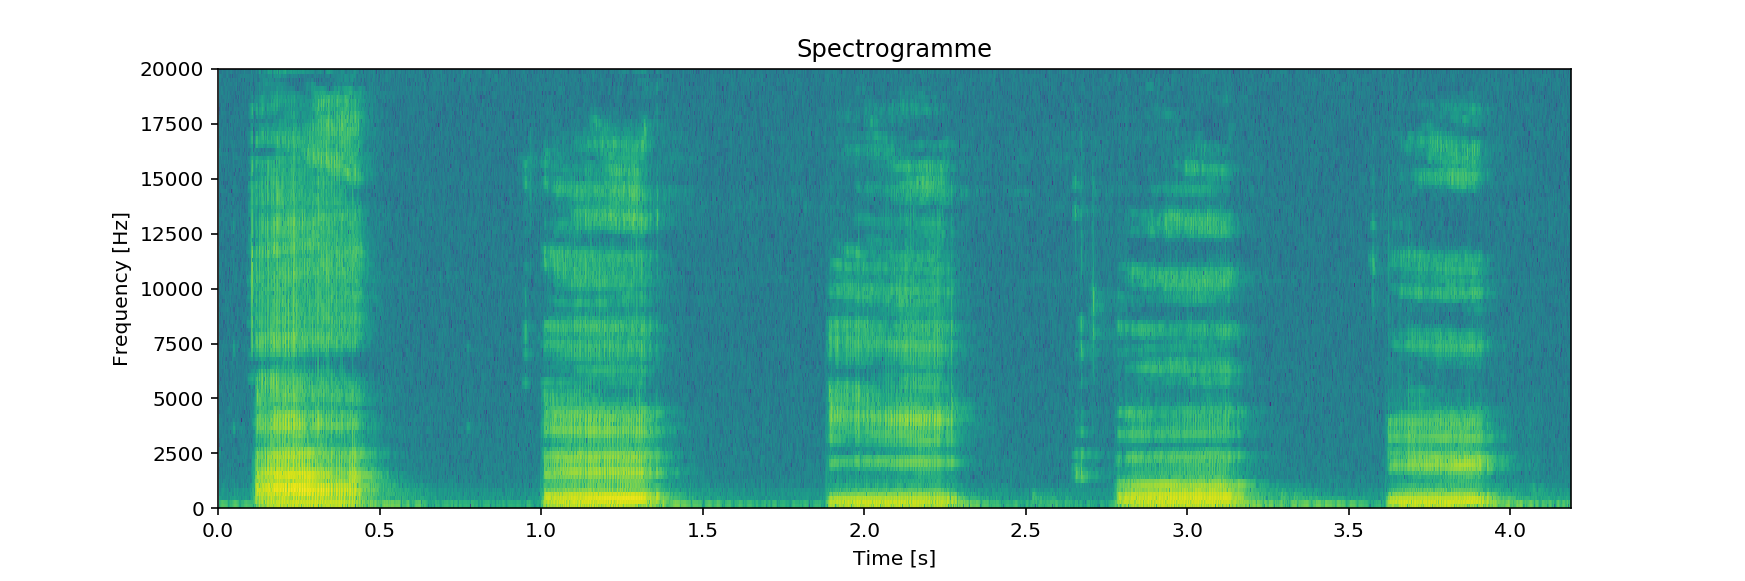

In [6]:
%run -i bin/plot_specgram.py
plot_specgram(y, t, fs)

# > Le compresseur audio

Les compresseur audio *(ou Dynamic Range Compressor)* permet d'amplifier les valeurs en dessous d'un seuil bas, et d'atténuer les valeurs au dessus d'un seuil haut. Cela peut notamment permettre de limiter l'effet des fortes variations d'amplitudes et éviter de fausser l'échelle utilisée, celle-ci utilisant l'amplitude maximum comme valeur de référence.

La fonction [**drcz**](https://github.com/lowlighter/sound/blob/master/bin/drcz.py) permet d'afficher la réponse en gain d'un compresseur audio.

<IPython.core.display.Javascript object>


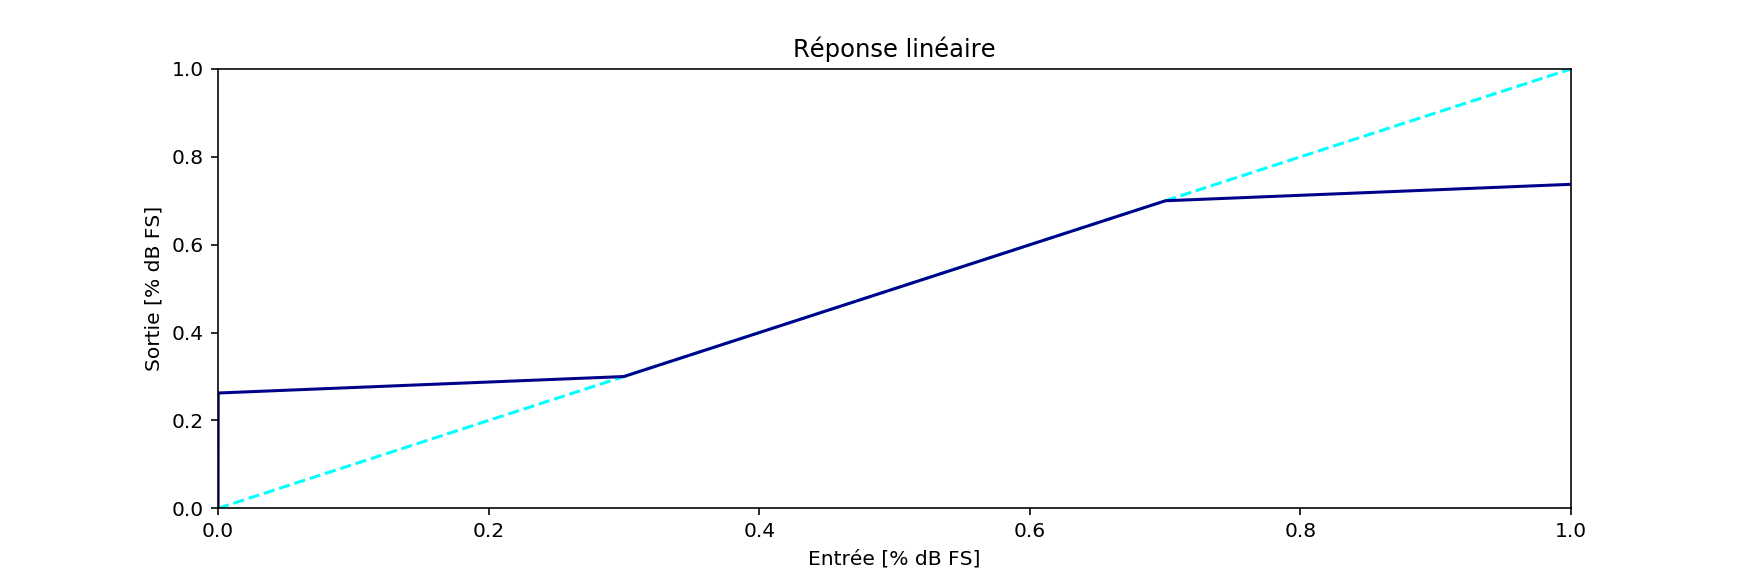

In [7]:
%run -i bin/drc.py
%run -i bin/drcz.py
drcz(tl=0.3, th=0.7, ratio=1/8)

Généralement, seul le seuil haut sera utilisé, étant donné que le seuil bas a tendance à amplifier les bruits parasites.

La fonction [**drc**](https://github.com/lowlighter/sound/blob/master/bin/drc.py) permet d'appliquer un compresseur audio à un signal d'entrée.

<IPython.core.display.Javascript object>


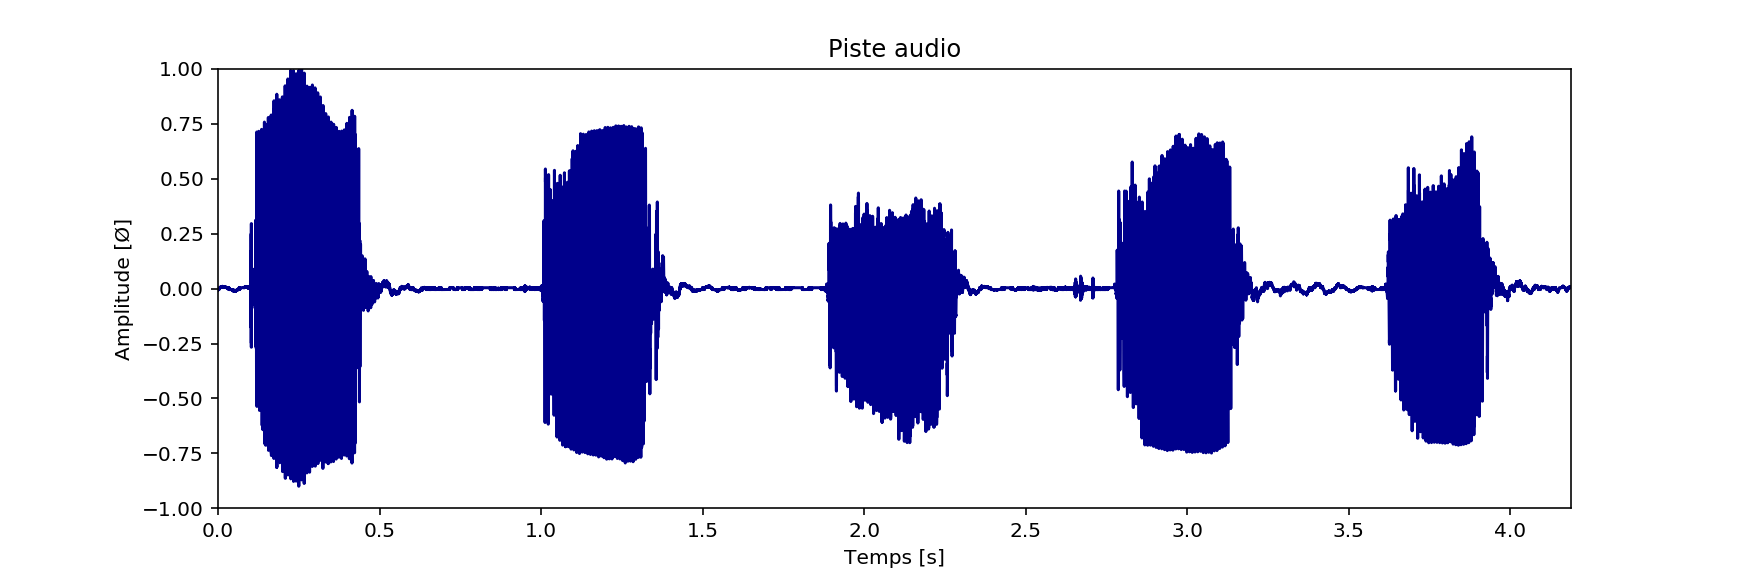

In [8]:
cy = drc(y, tl=10, th=1500, ratio=1/8)
plot_specamp(cy/max(abs(cy)), t)

Comme vous pouvez le constatez, le compresseur audio a permis d'égaliser les différentes amplitudes du fichier audio.

# > Le Convertisseur Analogique Numérique

Comme énoncé précédemment, nous avons supposé que le signal d'entrée était toujours analogique dans les parties précédentes. Afin de pouvoir passer dans la partie traitement du signal numérique, il est nécessaire de convertir le signal.

La fonction [**adc**](https://github.com/lowlighter/sound/blob/master/bin/adc.py) permet de numériser le signal d'entrée.

*Il est conseillé d'utiliser au moins 3 bits pour numériser le signal.*

<IPython.core.display.Javascript object>


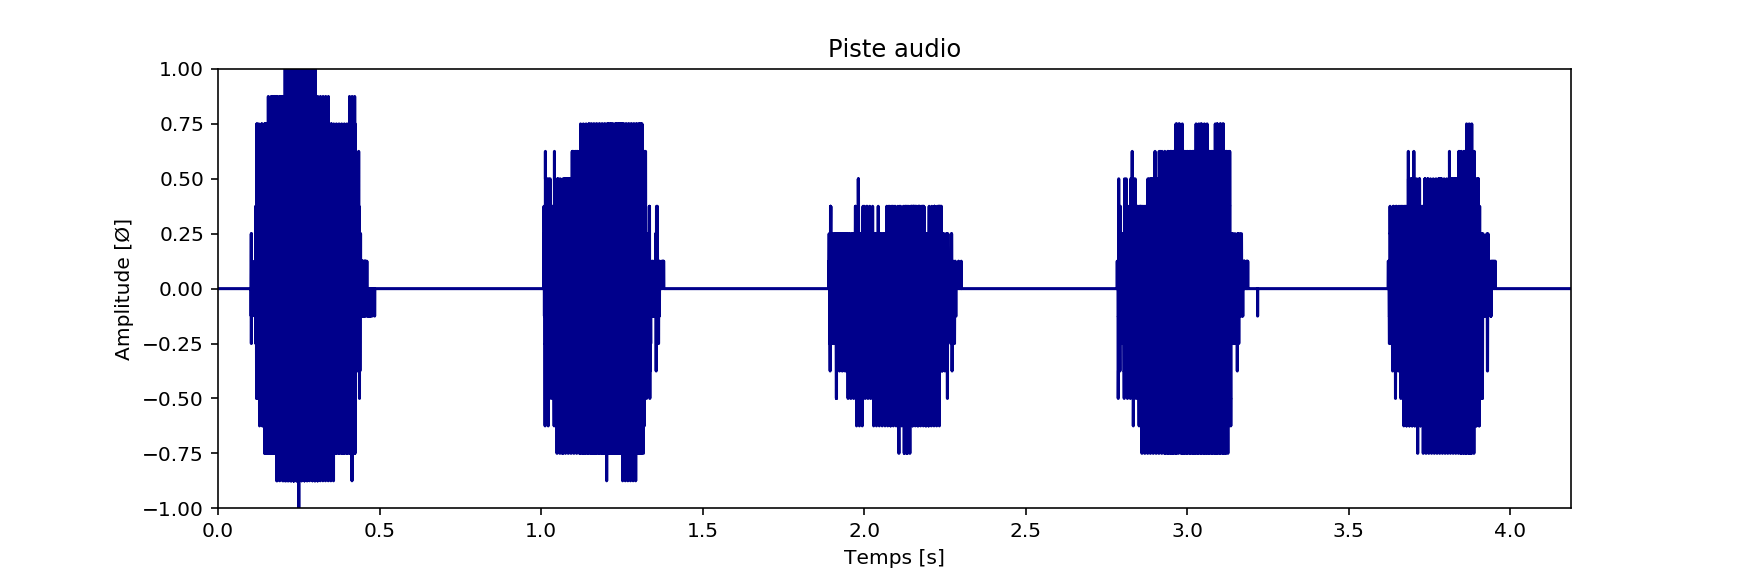

Help on function adc in module __main__:

adc(y, n)
    Convertisseur analogique numérique
    > y : Signal analogique
    > n : Nombre de bits utilisé pour la conversion
    < y : Signal numérique



In [9]:
%run -i bin/adc.py
yn = adc(cy, 8)
plot_specamp(yn/max(abs(yn)), t)
help(adc)

A partir d'ici, nous noterons **yn** le signal audio numérisé.

# > La Banque de filtres

Pour détecter les caractéristiques du signal audio *(ou Audio features)*, nous allons faire passer notre signal à travers une banque de filtres.

La fonction [**gen_filters**](https://github.com/lowlighter/sound/blob/master/bin/gen_filters.py) effectue plusieurs appels à la fonction [**bandpass**](https://github.com/lowlighter/sound/blob/master/bin/bandpass.py) afin de générer la banque de filtres.

La fonction [**plot_freqz**](https://github.com/lowlighter/sound/blob/master/bin/plot_freqz.py) permet d'affiche les réponses fréquentielle de chaque filtre sur un graphe logarithmique limité à la plage des sons audibles par l'oreille humaine *(environ 20Hz à 20kHz)*.

Voici les différents paramètres avec lesquels on peut interagir :
* Le nombre de filtres noté **nb_filters**
* L'ordre des filtres noté **n**
* Le facteur qualité noté **Q**
* Les fréquences centrales de chaque filtre (caractérisé par **fcs** ou par **fmin** et **fmax**)

Dans le cas où seul **fmin** et **fmax** sont connus, on se permettra de générer automatiquement les filtres selon une échelle logarithmique ou de Mel.

*Il est important de garder à l'esprit que la génération recquiert la valeur de **fs**, ce qui implique que si vous mélanger des fichiers audios n'ayant pas la même fréquence d'échantillonage, il se peut qu'une erreur soit retournée si la fréquence de Nyquist n'est plus respectée.*

In [10]:
%run -i bin/bandpass.py
%run -i bin/gen_filters.py
%run -i bin/plot_freqz.py

#### Exemple d'une banque de filtre

Fc :  300Hz ( 150Hz -  450Hz)
Fc :  416Hz ( 208Hz -  625Hz)
Fc :  579Hz ( 289Hz -  868Hz)
Fc :  804Hz ( 402Hz - 1207Hz)
Fc : 1118Hz ( 559Hz - 1677Hz)
Fc : 1553Hz ( 776Hz - 2330Hz)
Fc : 2159Hz (1079Hz - 3238Hz)
Fc : 3000Hz (1500Hz - 4500Hz)


<IPython.core.display.Javascript object>


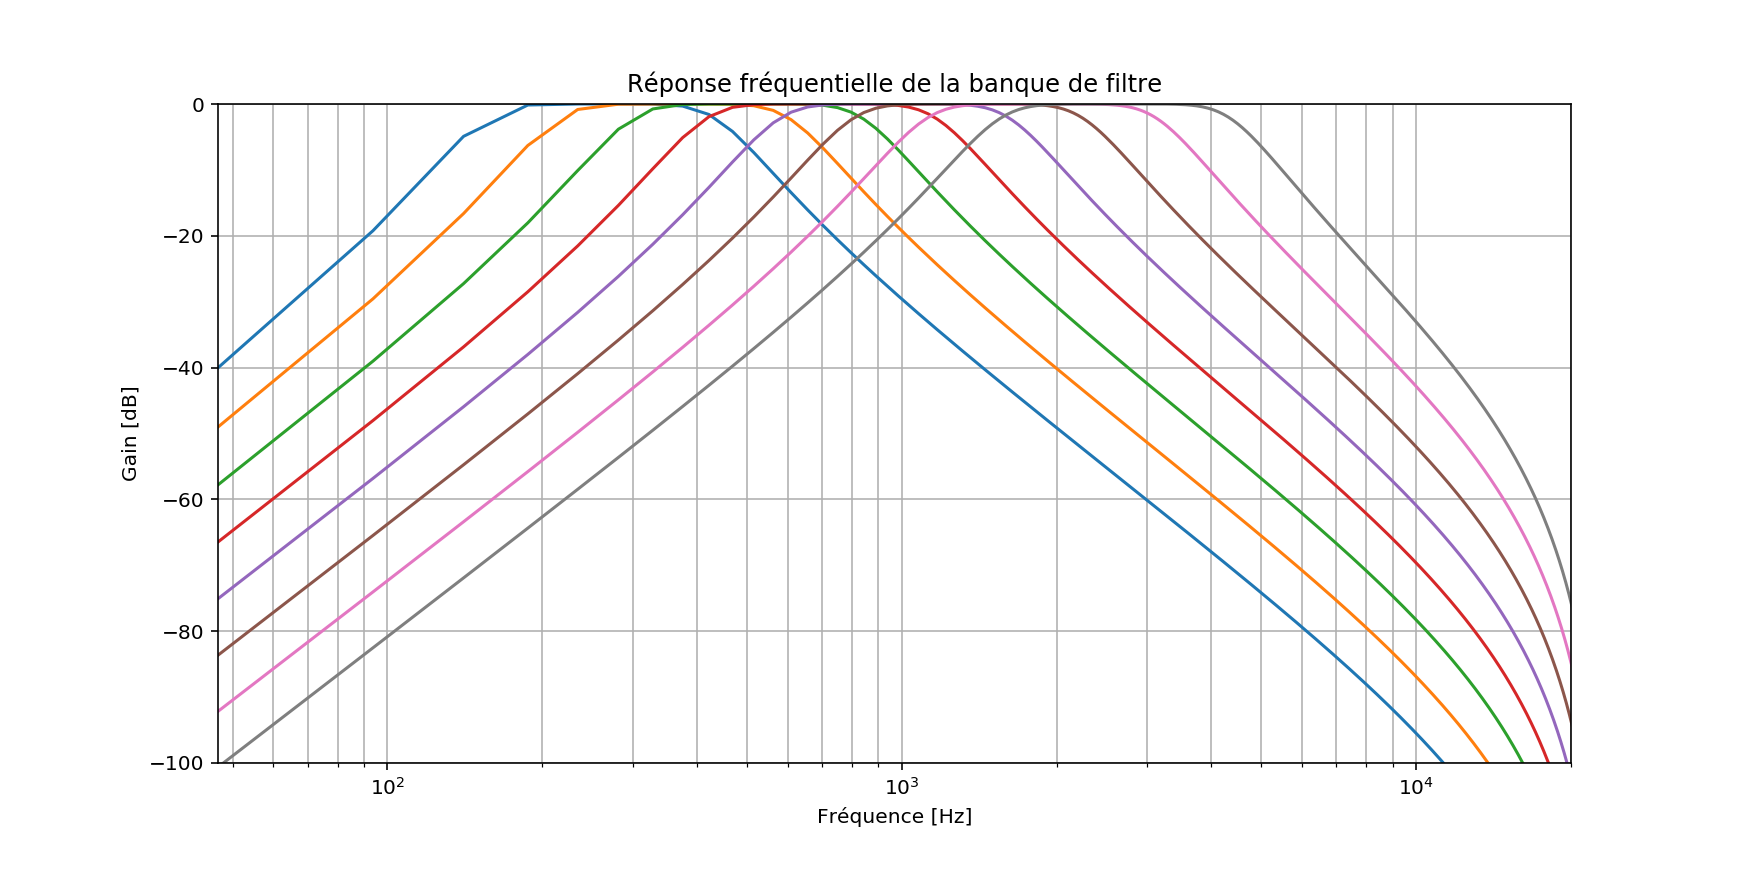

bin/plot_freqz.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx((fs/(2*np.pi))*w, 20 * np.log10(abs(h)));


In [11]:
filters, filters_fq = gen_filters(q=1, n=3, fs=fs, nb_filters=8, fmin=300, fmax=3000, debug=True, scale="log")
plot_freqz(filters)

Il est nécessaire de trouver l'équilibre entre le facteur de qualité **Q** et le nombre de filtres **nb_filters** afin de pouvoir couvrir l'intégralité de la plage de fréquence voulue pour éviter de manquer certaines caractéristiques audios par la suite.

### Application de la banque de filtres

La fonction [**gen_filtered**](https://github.com/lowlighter/sound/blob/master/bin/gen_filtered.py) permet de récupérer les signaux en sortie de la banque de filtres, et la fonction [**plot_filtered**](https://github.com/lowlighter/sound/blob/master/bin/plot_filtered.py) affiche le spectre d'amplitude du signal filtré *(en bleu marine)* par rapport au signal d'origine *(en bleu aquatique)*.

<IPython.core.display.Javascript object>


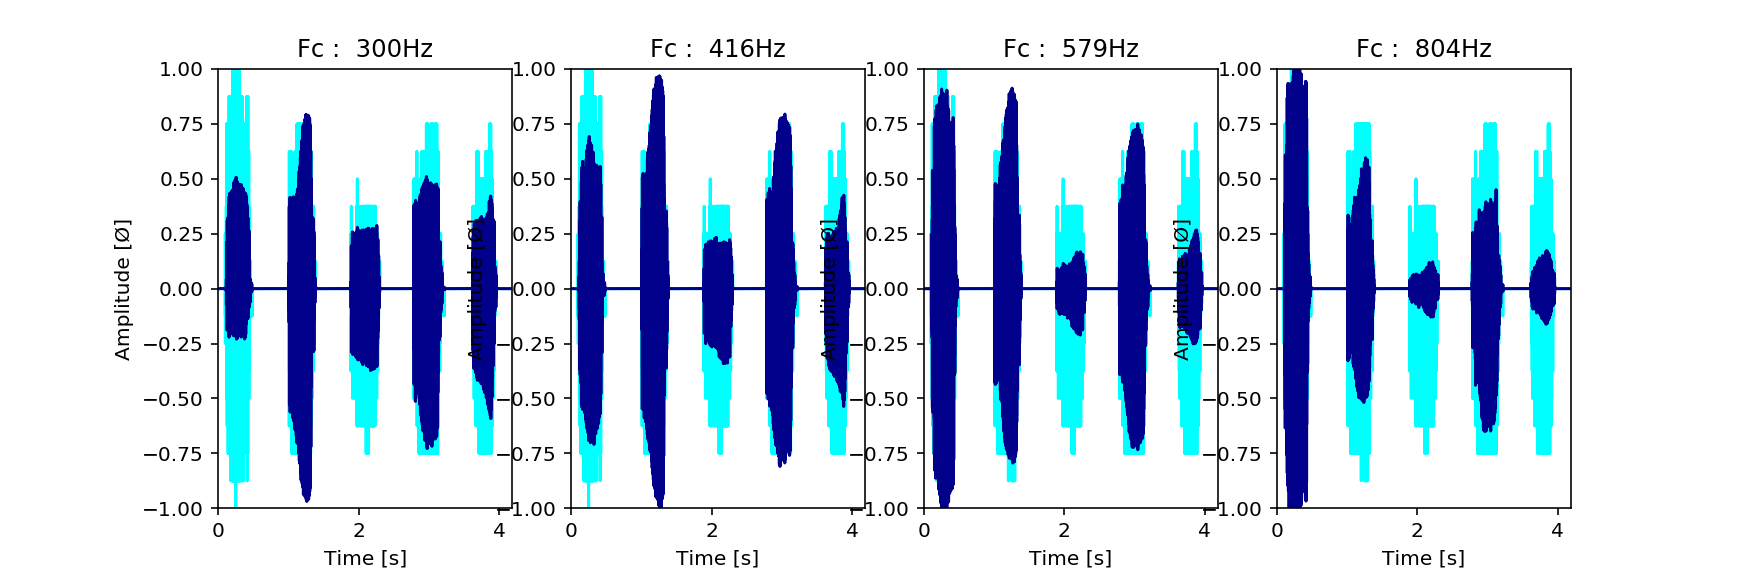

<IPython.core.display.Javascript object>


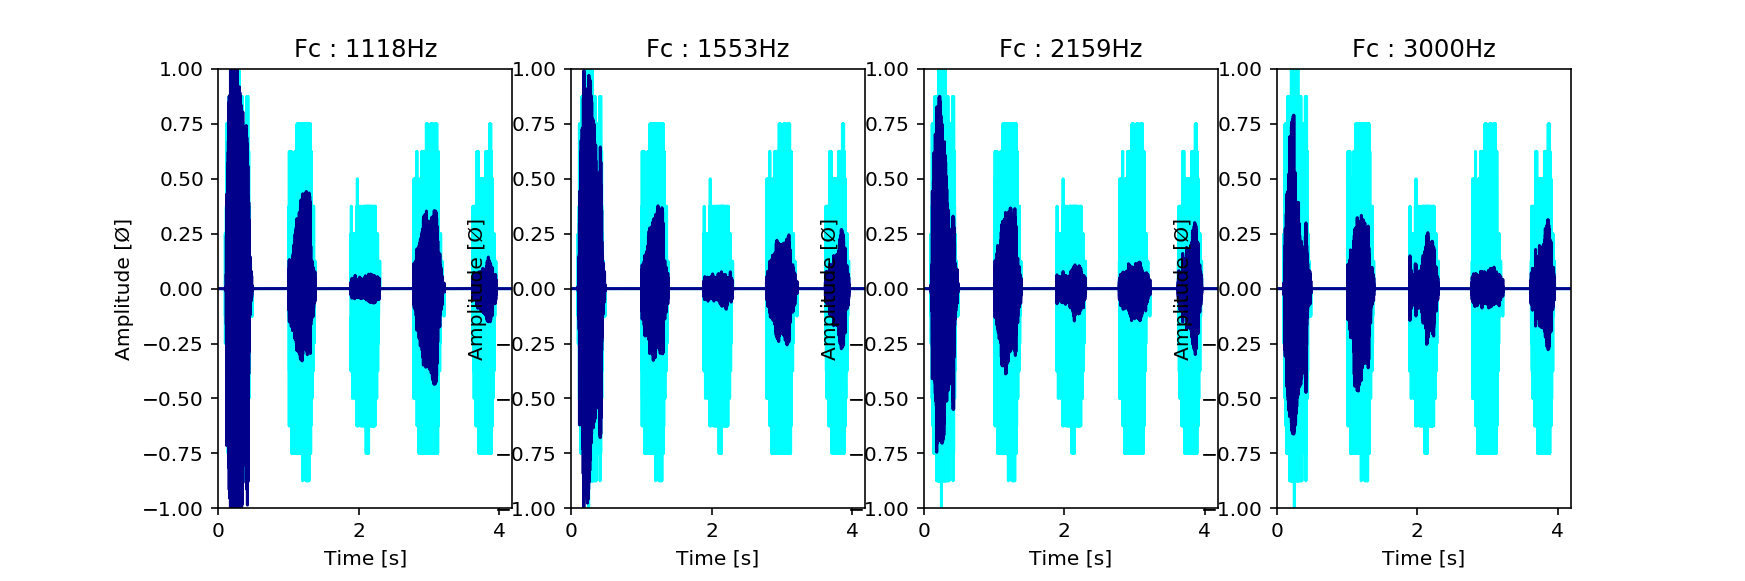

In [12]:
%run -i bin/gen_filtered.py
%run -i bin/plot_filtered.py
filtered = gen_filtered(yn, fs, filters)
plot_filtered(yn, t, filtered, filters_fq)

# > Les Quantifieurs d'énergie

Afin de repérer et identifier des *Audio Features*, nous allons mettre en place un système qui permet d'afficher les zones contenant le plus d'énergie.

Nous utiliserons la formule suivante pour calculer l'énergie d'un signal sur un certain segment temporel.
$$E = \sum_{t=t_0}^{t_0+dt}|y(t)^2| $$

La fonction [**energy**](https://github.com/lowlighter/sound/blob/master/bin/energy.py) permet de quantifier sur un certain nombre de bits l'energie contenue dans un interval de temps, et la fonction [**energies**](https://github.com/lowlighter/sound/blob/master/bin/energies.py) applique le calcul d'énergie sur tout le signal *(Notez qu'il est nécessaire de s'assurer que le pas **dt** peut être satisfait pas **fs**)*. 

La fonction [**plot_energies**](https://github.com/lowlighter/sound/blob/master/bin/plot_energies.py) permet d'afficher le résultat.

Ci-dessous s'affiche les zones d'énergies du second filtre avec une résolution temporelle de 10 ms et une résolution d'amplitude de 4 bits. Visuellement, on peut constater que ce filtre est plus sensible à la voyelle *"E"*.

<IPython.core.display.Javascript object>


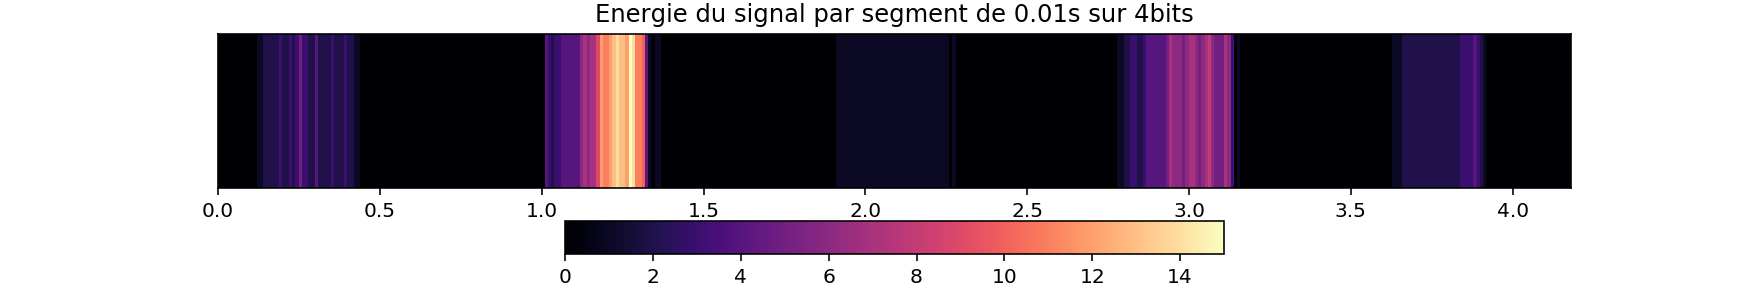

In [13]:
%run -i bin/energy.py
%run -i bin/energies.py
%run -i bin/plot_energies.py
plot_energies(filtered[1], fs, 0.01, bits=4)

La fonction [**gen_data**](https://github.com/lowlighter/sound/blob/master/bin/gen_data.py) permet d'effectuer tous différents calculs d'énergie, et la fonction [**plot_data**](https://github.com/lowlighter/sound/blob/master/bin/plot_data.py) permet d'afficher le résultat.

<IPython.core.display.Javascript object>


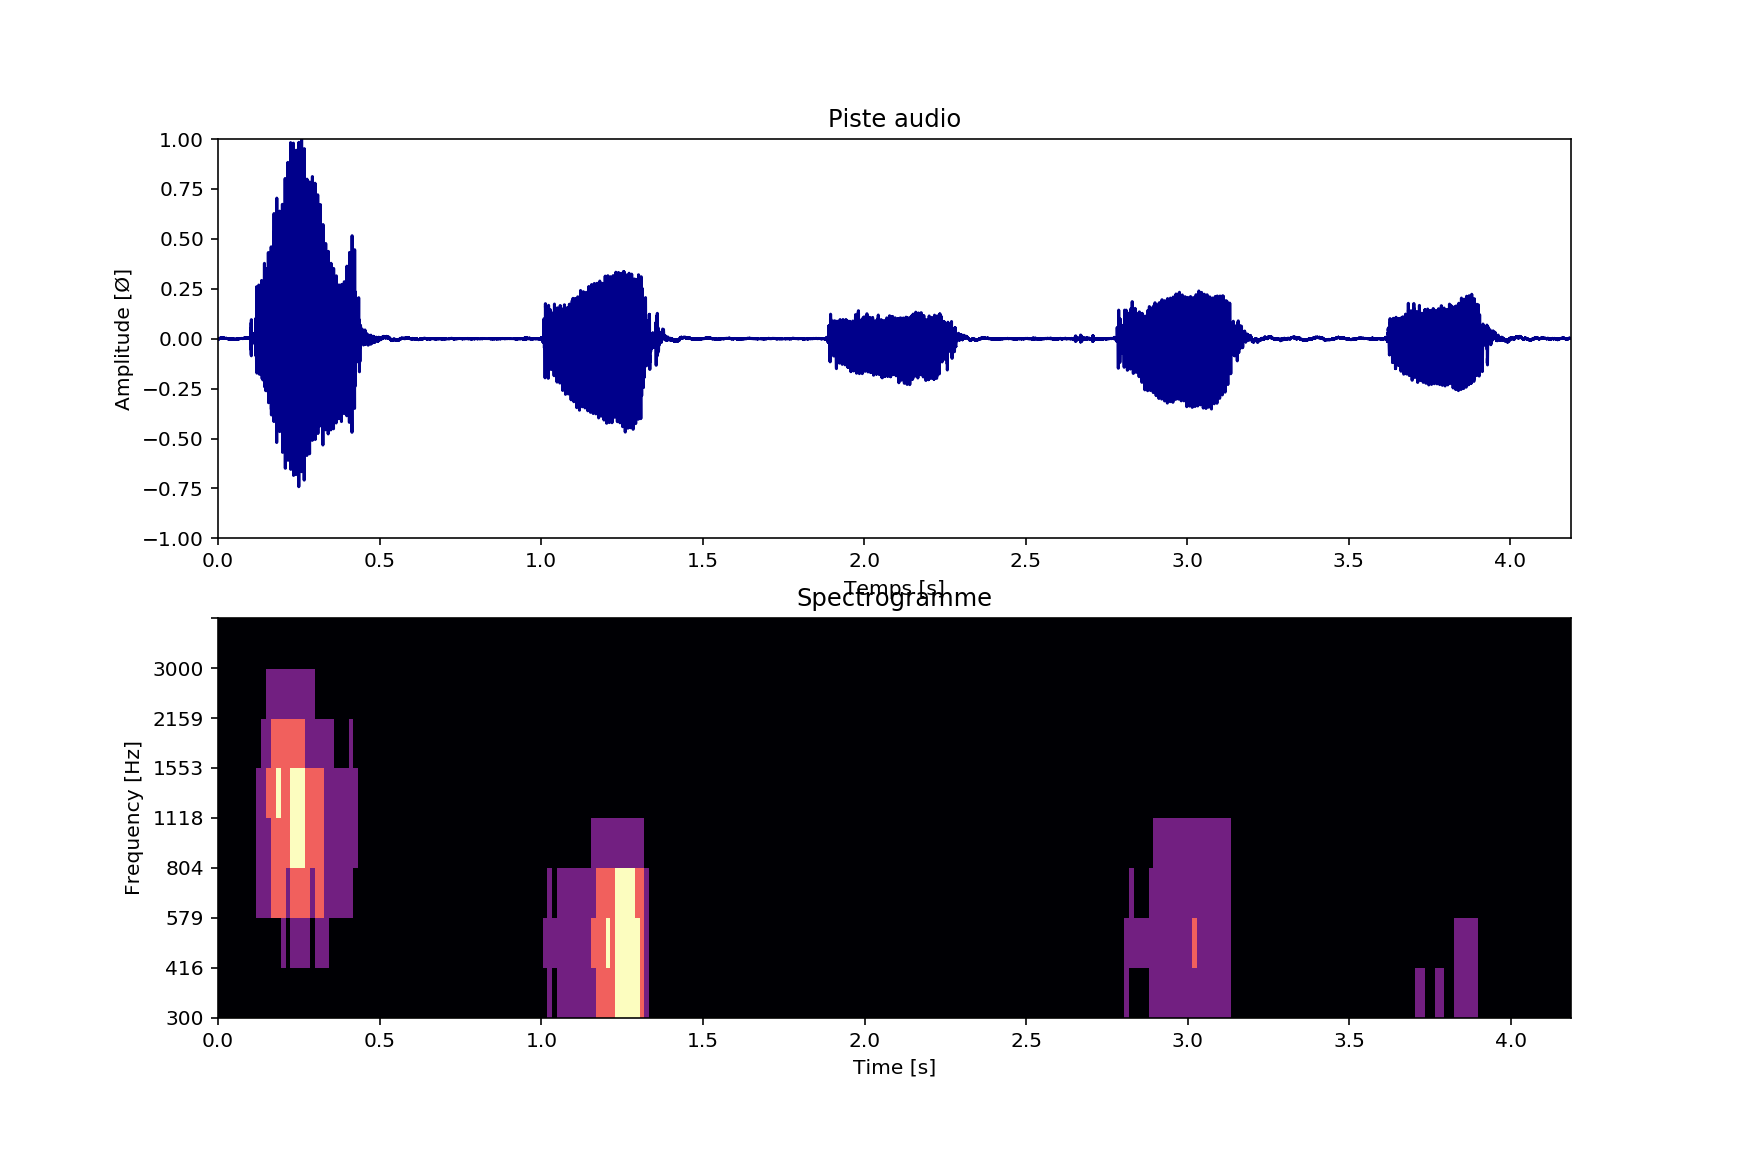

In [14]:
%run -i bin/gen_data.py
%run -i bin/plot_datagram.py
%run -i bin/plot_data.py
%run -i bin/plot_formants.py
rsegs, rfreqs, rseqs = gen_data(filtered, fs, 0.015, 2, filters_fq)
plot_data(y, t, rsegs, rfreqs, rseqs, dbfs=False)

#### Accès aux données

La fonction [**state_at(filter_no, s, rsegs, rseqs, debug=False)**](https://github.com/lowlighter/sound/blob/master/bin/state_at.py) permet de lire facilement la valeur de l'énergie quantifiée pour un filtre et un temps donnés.

In [15]:
%run -i bin/state_at.py
print(state_at(math.floor(len(filtered)/2), 0.18, rsegs, rseqs, debug=True))

Valeur numérique du filtre n°4 pour t=0.18s
3.0


Selon la vitesse de prononciation des personnes, il se peut que les bandes d'énergies caractéristiques soient plus ou moins espacés, ce qui peut fausser l'analyse. 

La fonction [**cut**](https://github.com/lowlighter/sound/blob/master/bin/cut.py) permet d'isoler les différentes bandes d'énergies en supprimant les bandes noires.

In [16]:
%run -i bin/cut.py
cut(rseqs, debug=True);

6 parties différentes :
    0 : Largeur 21
    1 : Largeur 22
    2 : Largeur 22
    3 : Largeur 2
    4 : Largeur 2
    5 : Largeur 5


# > Etude des Audio Features

La fonction [**compute**](https://github.com/lowlighter/sound/blob/master/bin/compute.py) permet de passer par toutes les étapes précédemment évoquées, c'est-à-dire la récupération du signal audio, l'application du compresseur audio et de la banque de filtres ainsi que la quantification d'énergie.

| | |
| :--- | :--- |
| **Récupération du signal** | La source du fichier peut-être soit un chemin de fichier (**file**) ou un fichier déjà ouvert (**file** et **fs**). |
| **Compresseur audio** | Pour activer le compresseur audio, il suffit de spécifier le ration de celui-ci (**drc_r**) ainsi qu'un (ou les deux) seuil(s) d'activation (**drc_tl** et **drc_th**). |
| **Conversion analogique numérique** | Il est possible de changer le nombre de bits utilisé pour numériser le signal d'entrée (**adc_res**), dans la limite de 16 bits. |
| **Banque de filtres** | Les filtres peuvent être générés automatiquements (avec **fmin**, **fmax**, **nb_filters**, **q** et **n**) ou avec des fréquences centrales spécifiques (avec **fcs=[fc1, fc2..., fcn]**, **q** et **n**) ou bien il est également possible d'utiliser des filtres déjà générés (avec **filters** et **filters_fq**, qui sont les sorties de la fonction **gen_filters**). |
| **Paramètres du spectrogramme** | La résolution temporelle (**time_res**) et le nombre de bits pour caractériser une amplitude d'énergie (**amp_res**) permettent de configurer l'aspect général du spectrogramme. Il est possible de masquer l'affichage du spectre d'amplitude en activant l'option (**spec_only**) et de modifier les limites en abscisse (**spec_xlim**). |
| **Paramètres d'affichage** | Par défaut de nouvelles figures seront générées à chaque appel, cependant il est possible d'en réutiliser des anciennes (**ax**) ou de désactiver l'affichage (**plotd**, activé par défaut). Le spectre dB FS peut être ajoutée en activant l'option associée (**dbfs**) et il est possible de tracer différents formants de sons connus pour faciliter l'étude (**formants=[tolerance, "a", "e", ...]**). |

<IPython.core.display.Javascript object>


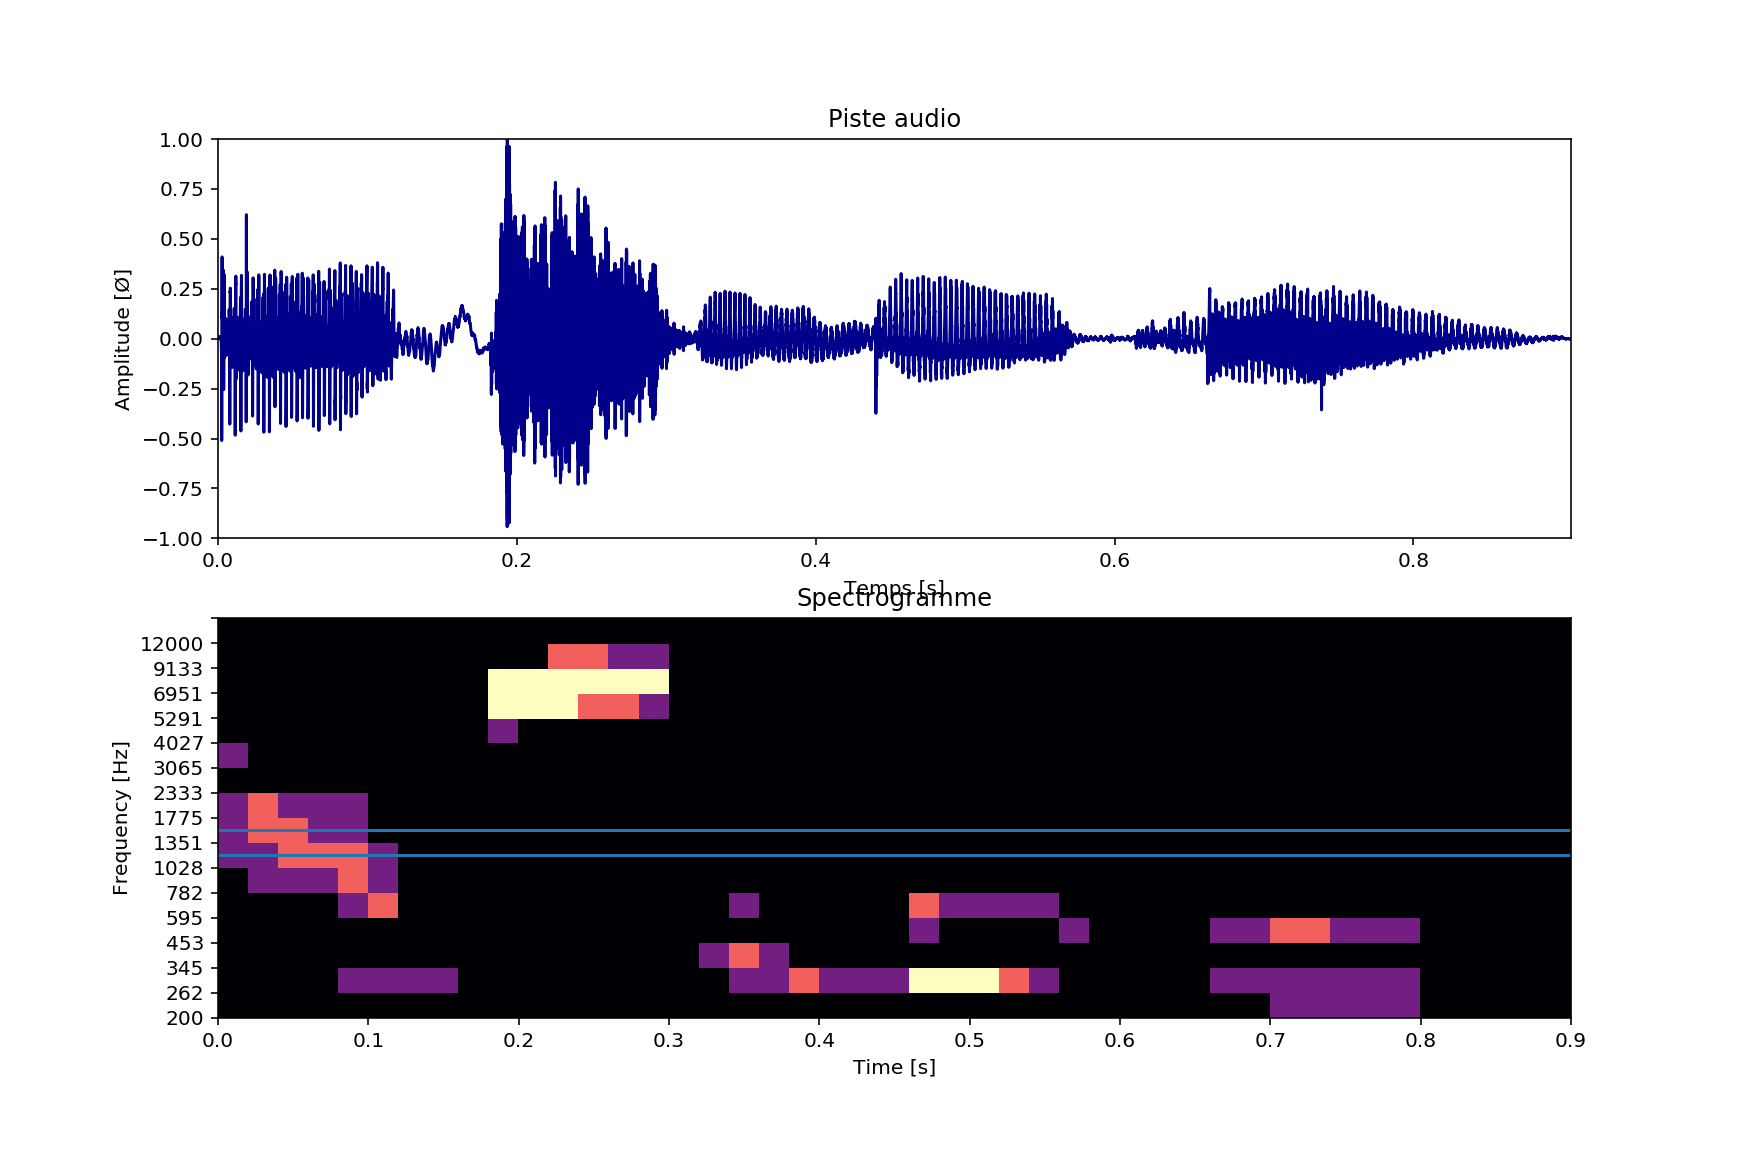

In [17]:
%run -i bin/plot_formants.py
%run -i bin/compute.py
rsegs, rfreqs, rseqs = compute(
    file="src/Words/voice_F1_absolutely_2.wav", 
    fmin=200, 
    fmax=12000, 
    nb_filters=16, 
    q=3, 
    n=3, 
    time_res=0.02, 
    amp_res=2,
    formants=[150, "a"]
);

### Comparaison

La fonction [**compare**](https://github.com/lowlighter/sound/blob/master/bin/compare.py) permet de pouvoir comparer plusieurs fichiers différents avec la même configuration du système. Les paramètres d'entrées sont sensiblement les mêmes que la fonction **compute** à la différence du paramètre de fichiers (**files=["sound1", "sound2", ...]**).

Le code ci-dessous permet de visualiser les spectrogrammes du mot **together** et **gentleman** prononcé par deux personnes différentes.

C:\ProgramUser\Anaconda\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


<IPython.core.display.Javascript object>


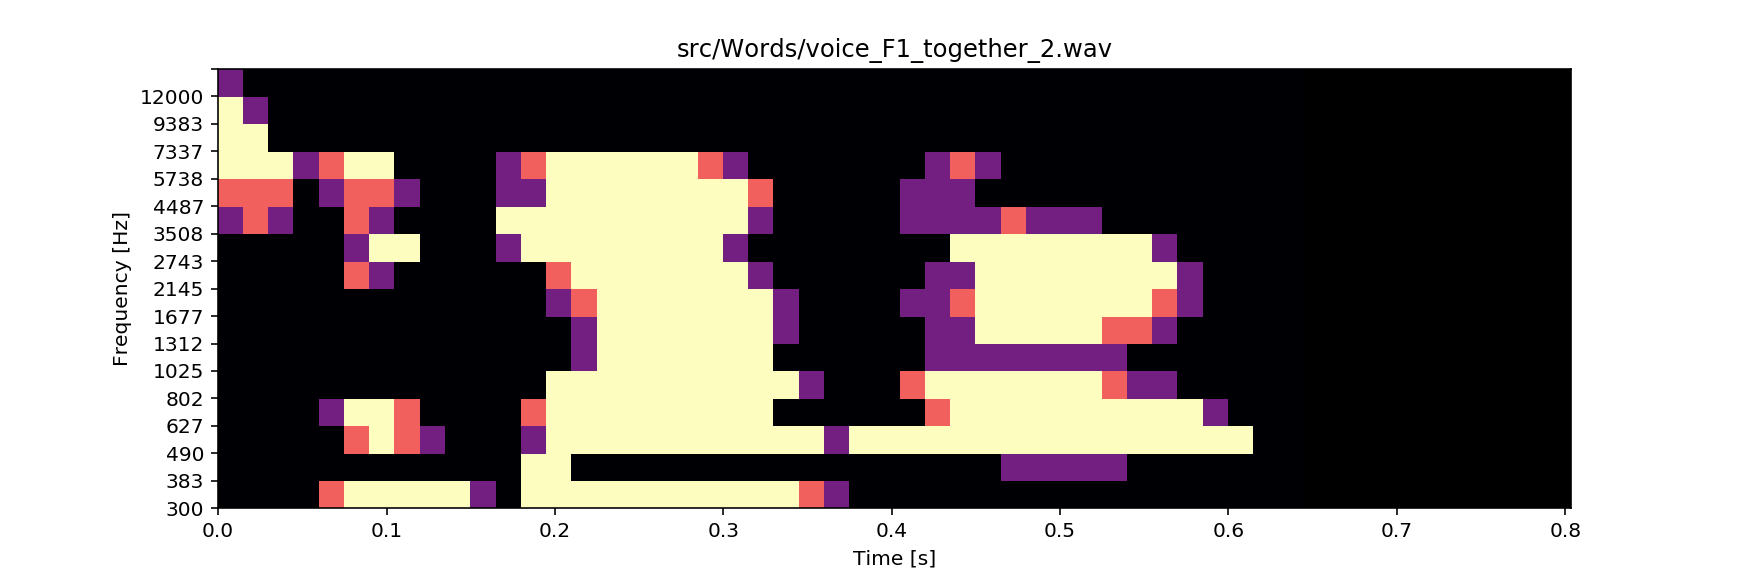

<IPython.core.display.Javascript object>


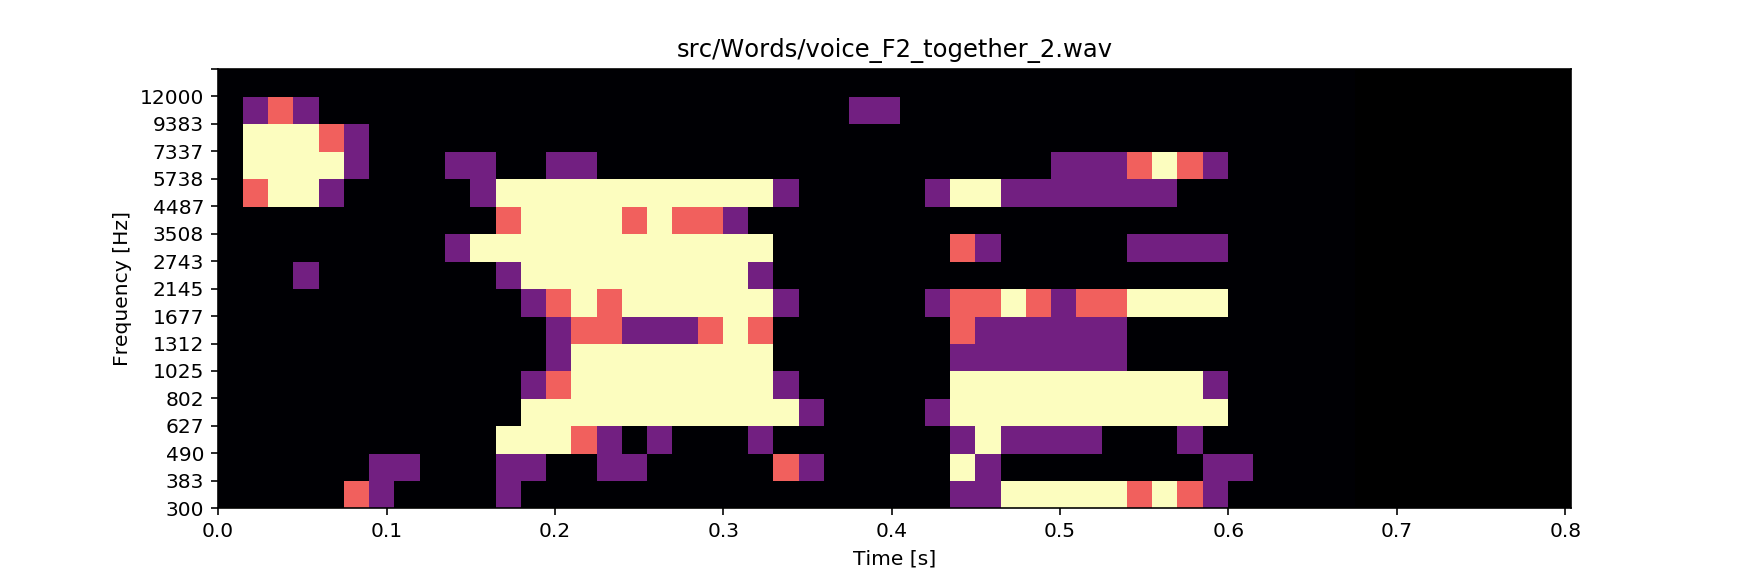

<IPython.core.display.Javascript object>


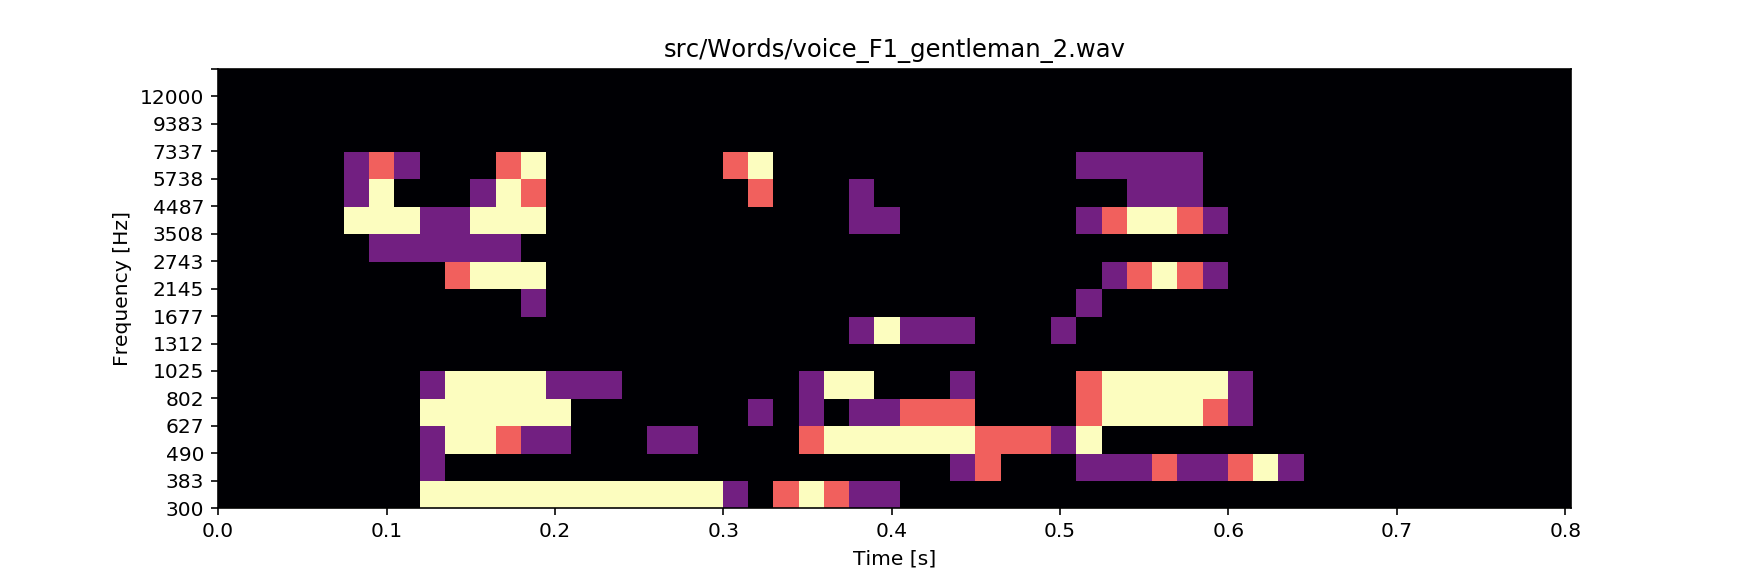

<IPython.core.display.Javascript object>


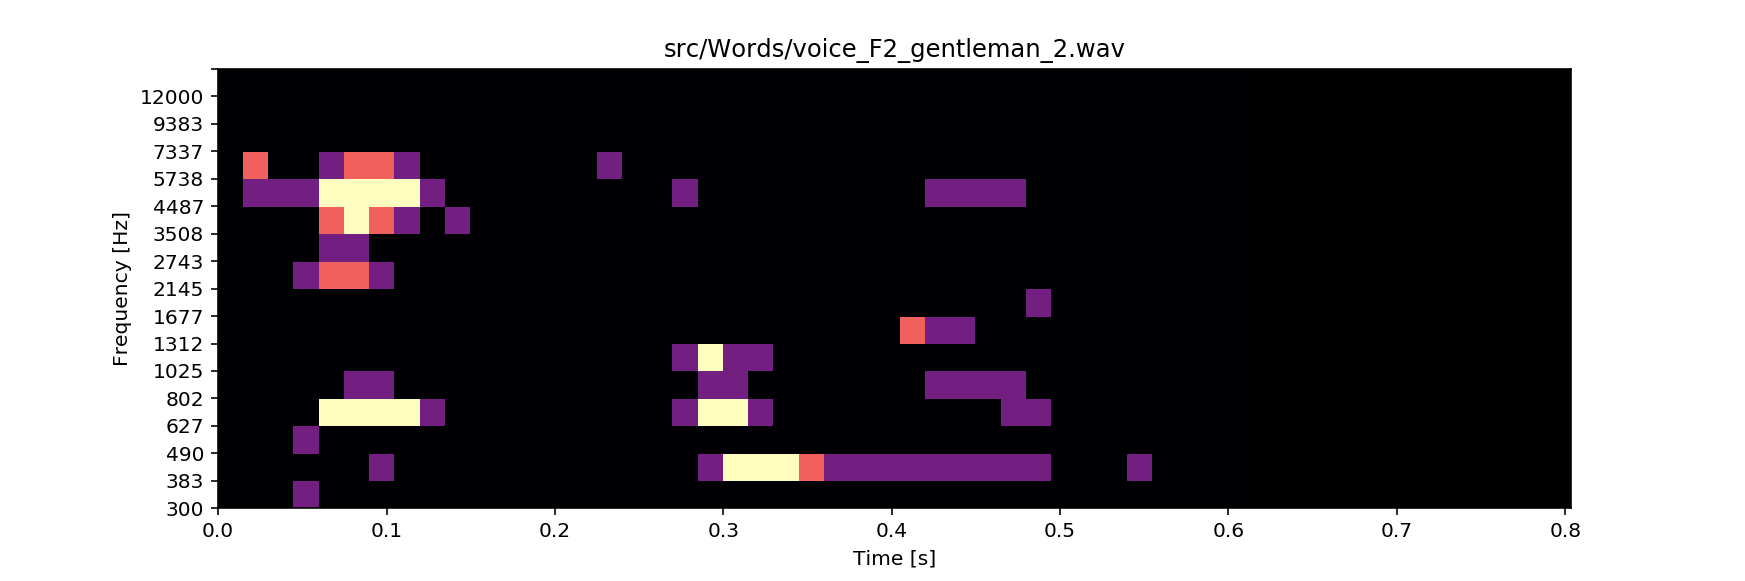

In [18]:
%run -i bin/compare.py
compared = compare(
    folder="src/Words/",
    files=["voice_F1_together_2", "voice_F2_together_2", "voice_F1_gentleman_2", "voice_F2_gentleman_2"],
    fmin=300, 
    fmax=12000, 
    nb_filters=16, 
    q=6, 
    n=3, 
    time_res=0.015, 
    amp_res=2
);

#### Coefficient de corrélation

Une des premières approches pour comparer deux signaux différents est d'utiliser une matrice de corrélation.

La fonction [**similarities**](https://github.com/lowlighter/sound/blob/master/bin/similarities.py) permet d'effectuer plusieurs appels successif à la fonction [**similar**](https://github.com/lowlighter/sound/blob/master/bin/similar.py) qui se charge de calculer un **score** de corrélation entre deux fichiers. 

Si deux fichiers sont identiques, le score est de 1. S'ils sont complètement différents, le score tend vers 0.

In [19]:
%run -i bin/similar.py
%run -i bin/similarities.py
similarities(compared, ["together (F1)", "together (F2)", "gentleman (F1)", "gentleman(F2)"])

together (F1) # together (F2) : 0.6806311216349221
together (F1) # gentleman (F1) : 0.40937565785030006
together (F1) # gentleman(F2) : 0.4405946666716778
---
together (F2) # gentleman (F1) : 0.4271011619485241
together (F2) # gentleman(F2) : 0.45109073842944836
---
gentleman (F1) # gentleman(F2) : 0.5091352971160622


C:\ProgramUser\Anaconda\lib\site-packages\numpy\lib\function_base.py:3162: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramUser\Anaconda\lib\site-packages\numpy\lib\function_base.py:3163: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Toutefois, on observe que cette méthode a ses limites, puisque deux mots identiques peuvent avoir été prononcés d'une méthode différente, ce qui se répercutera sur les niveaux d'énergies et leur emplacement, ce qui empêche d'avoir un coefficient de corrélation précis.

#### Réseau de neurones artificiels

Une approche plus avancée consiste à utiliser un réseau de neurones artificiels. L'avantage de ce dernier est que l'on peut choisir ce que l'on veut en sortie *(voix ou bruit, homme ou femme, chien ou chat, etc.)*.

Après avoir récupéré le spectrogramme personnalisé, les entrées doivent être normaliser puisque le Perceptron Multi-couche ([**Multi-layer Perceptron classifier**](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)) que nous allons utiliser ne possède qu'une seule couche d'entrée.

La fonction [**to1D**](https://github.com/lowlighter/sound/blob/master/bin/to1D.py) permet de réaliser cette opération.

![Réseau de neurones artificiels](src/imgs/neurons.png)

Ensuite, il faut constituer un ensemble de données qui va *éduquer* le classificateur (e.g. des fichiers audios contenant le mot "*chat*" et "*chien*") qui lui servira de référence par la suite. Une fois le classificateur constitué, il suffit de le tester avec un nouvel ensemble de données afin d'estimer la qualité et précision du réseau de neurones artificiels.

La fonction [**learning**](https://github.com/lowlighter/sound/blob/master/bin/learning.py) permet de réaliser ces différentes étapes et d'afficher un rapport détaillé du classificateur et sa matrice de confusion.

Préparation des fichiers à traiter...
    98 fichiers d'apprentissage récupérés
    20 fichiers de test récupérés
     2 valeurs (chien, chat)

Acquisition des données...

C:\ProgramUser\Anaconda\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


    98 fichiers d'apprentissage traités
    20 fichiers de test traités

Apprentissage...
    98 fichiers utilisés
    20 prédictions

Rapport détaillé du classificateur :
             precision    recall  f1-score   support

       chat       0.89      0.80      0.84        10
      chien       0.82      0.90      0.86        10

avg / total       0.85      0.85      0.85        20



<IPython.core.display.Javascript object>


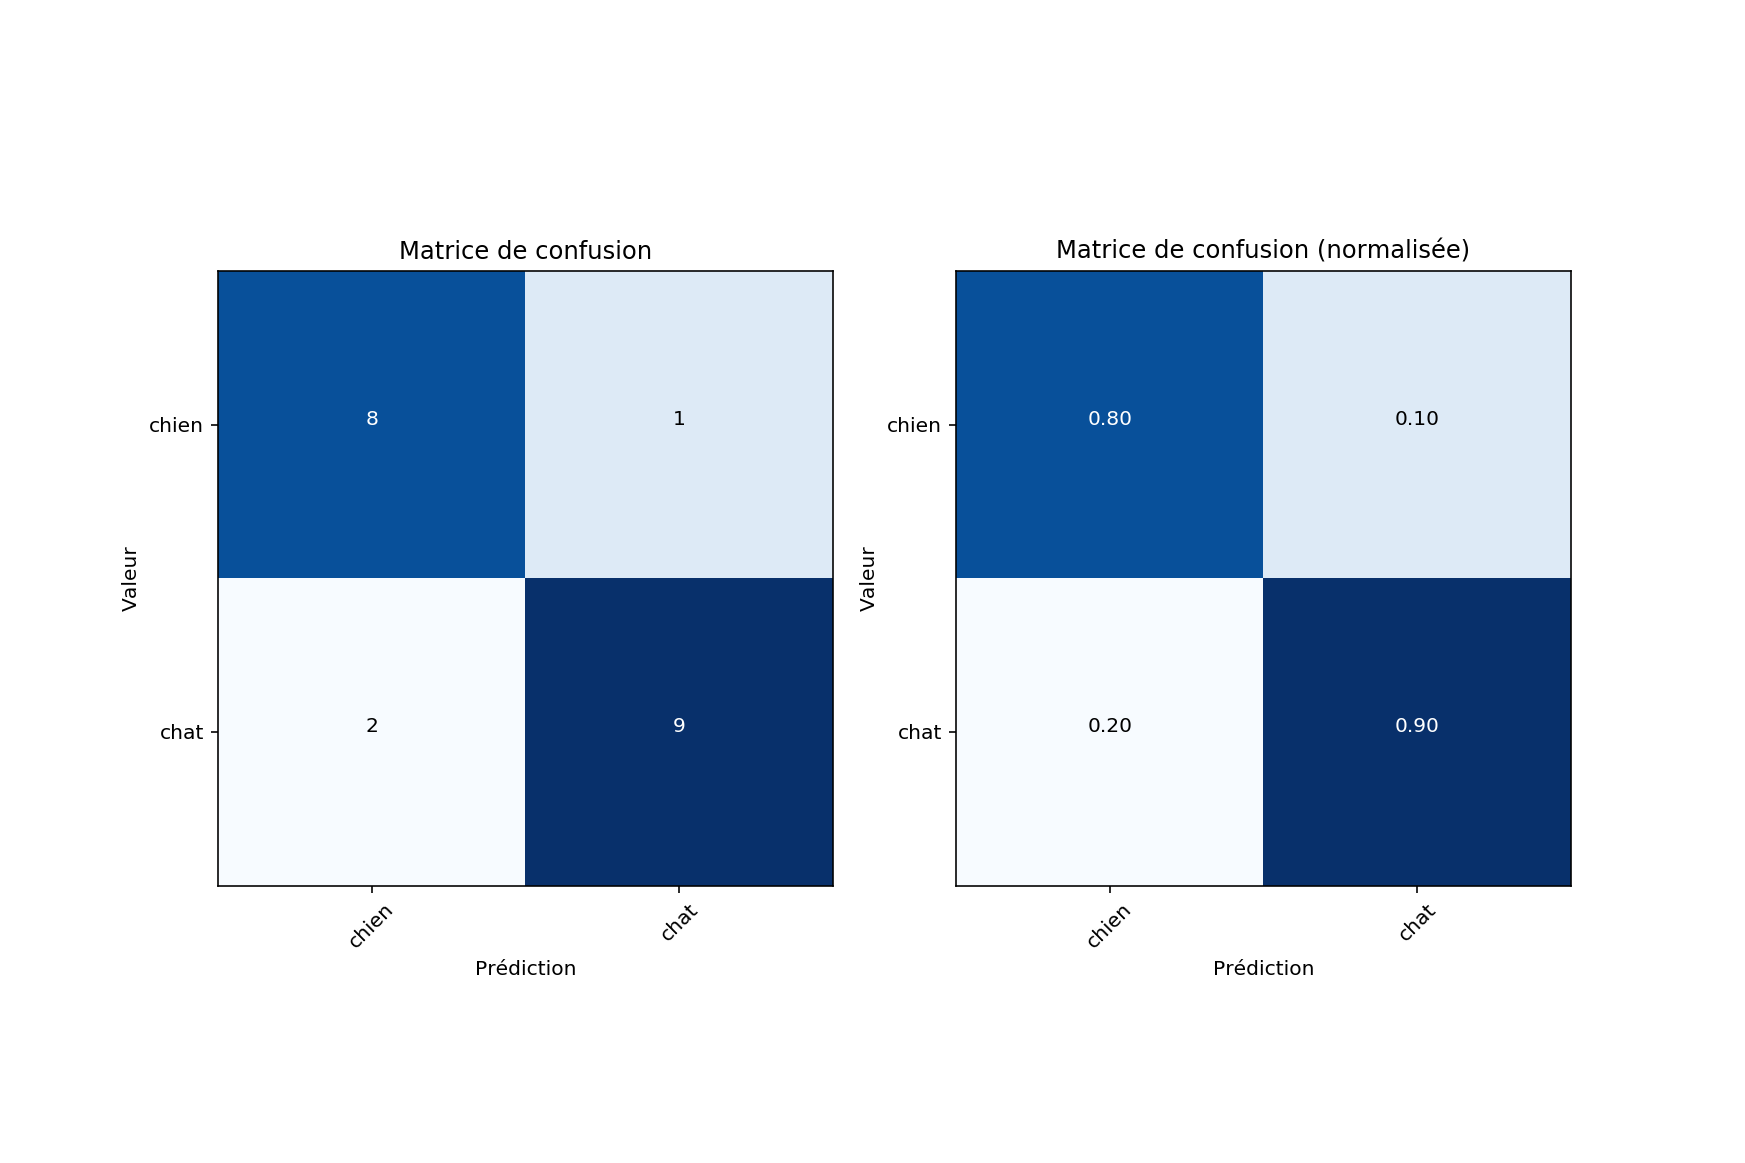

In [20]:
%run -i bin/to1D.py
%run -i bin/learning.py
predict = learning(
    learn=["chien{i:02}", "chat{i:02}"], learn_i=[49, 49], 
    test=["chien{i:02}", "chat{i:02}"], test_i=[10, 10], 
    options={"fmin":300, "fmax":12000, "nb_filters":16, "q":6, "n":3, "time_res":0.015, "amp_res":2},
    neurons=(100)
)

Les matrices de confusions ci-dessus permet de comprendre où le réseau de neurones artificels a commis des erreurs. La matrice de gauche n'est pas normalisée et affiche le nombre de prédictions correctes par support de test. La matrice de droite contient les mêmes informations à la seule différence que les valeurs sont comprises entre 0 et 1.

La fonction **learning** retourne en sortie une fonction anonyme qui permet de tester de nouveaux fichiers de test à partir de la même configuration *(n.b. le dossier contenant les échantillons de tests doit rester le même également)*.

In [21]:
predict(["chien01", "chien02", "chien03", "chat01", "chat02", "chat03"])

C:\ProgramUser\Anaconda\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


['chien' 'chien' 'chien' 'chat' 'chat' 'chien']


# > Paramètres optimum et courbes

A compléter.

# > Vérification des résultats 

Pour vérifier que le spectrogramme est cohérent, il suffit de générer un fichier audio contenant un sinus et s'assurer que le spectrogramme en sortie est cohérent.

La fonction [** gen_sine**](https://github.com/lowlighter/sound/blob/master/bin/gen_sine.py) permet de réaliser cette opération.

<IPython.core.display.Javascript object>


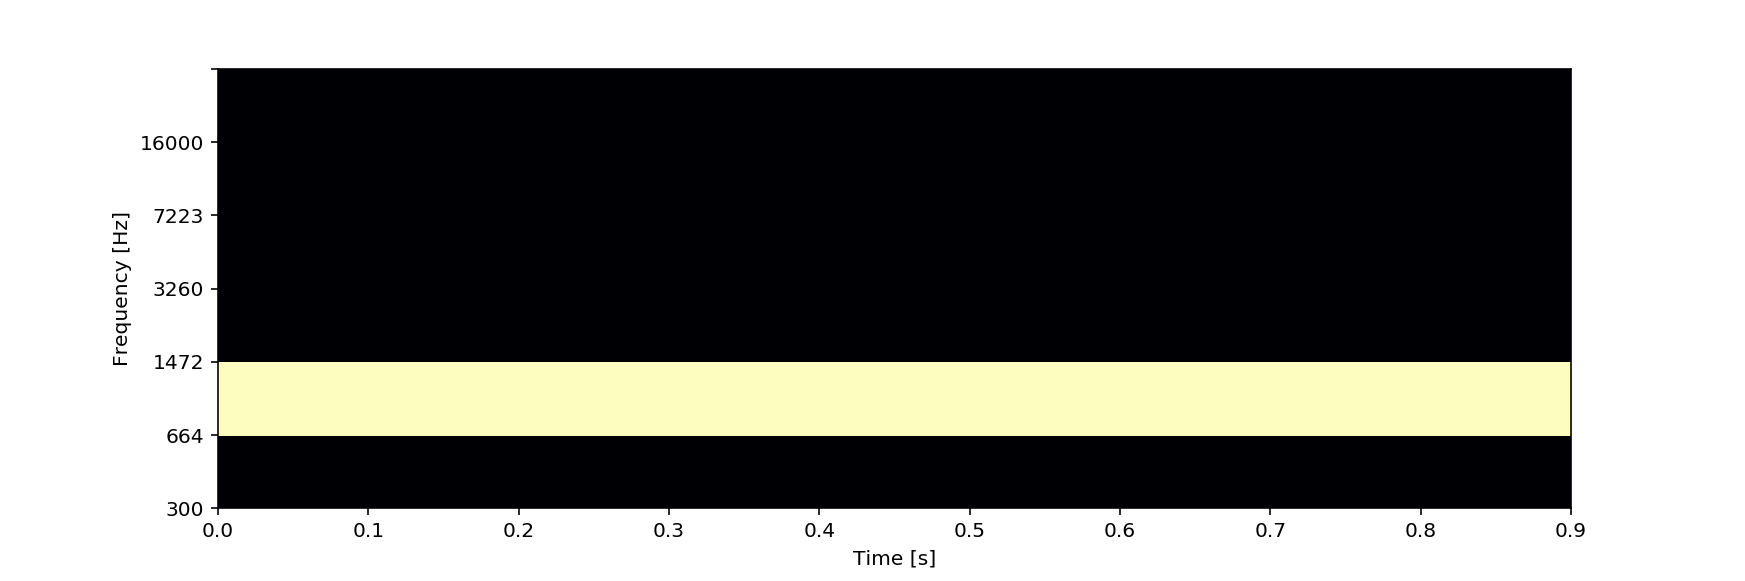

In [22]:
%run -i bin/gen_sine.py
fsin, fsin_fq = gen_filters(q=1.5, n=3, fs=fs, nb_filters=6, fmin=300, fmax=16000, scale="log")
gen_sine(f=750, duration=1, fs=fs, src_out="src/sine.wav")
compute(file="src/sine.wav", filters=fsin, filters_fq=fsin_fq, time_res=0.1, amp_res=2, spec_only=" ");

### Comparaison avec le spectrogramme natif

La fonction [**plot_nspecgram**](https://github.com/lowlighter/sound/blob/master/bin/plot_nspecgram.py) permet d'afficher l'implémentation classique supporté par python, que l'on peut donc comparer avec notre implémentation.

<IPython.core.display.Javascript object>


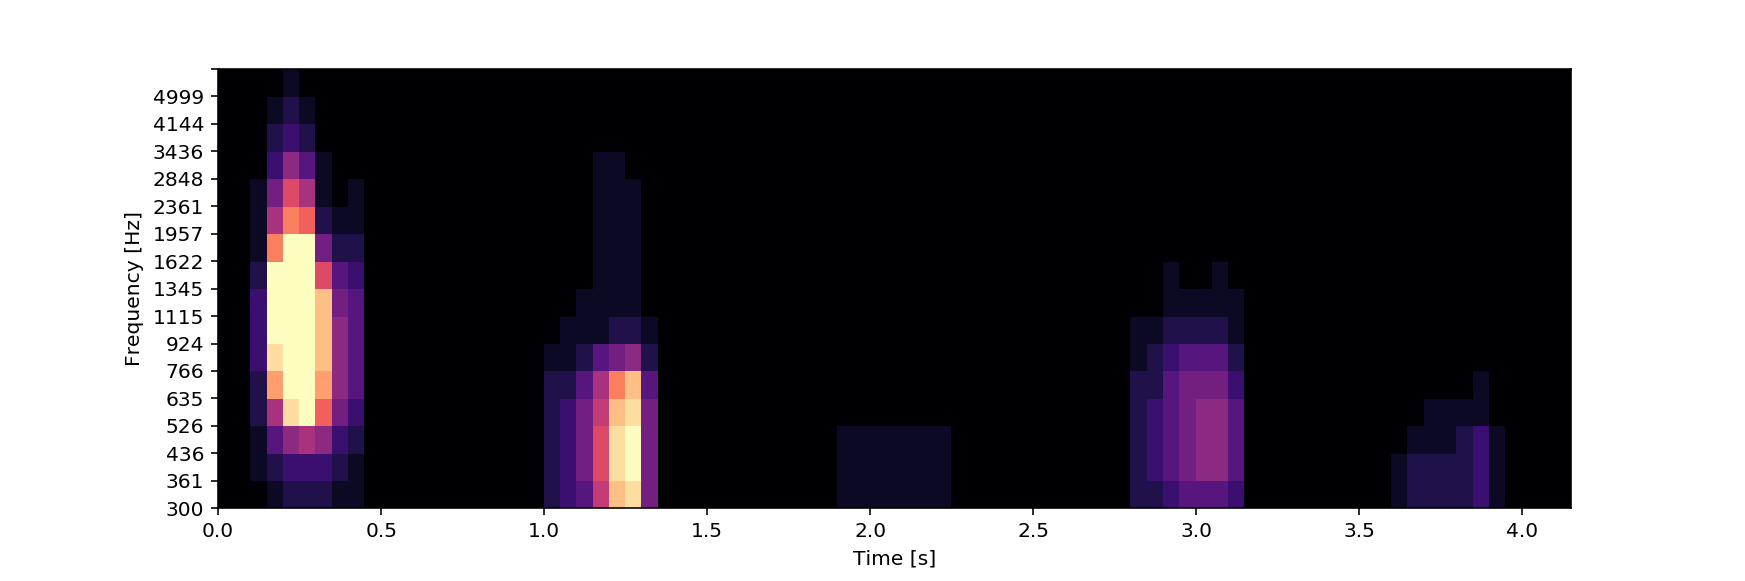

<IPython.core.display.Javascript object>


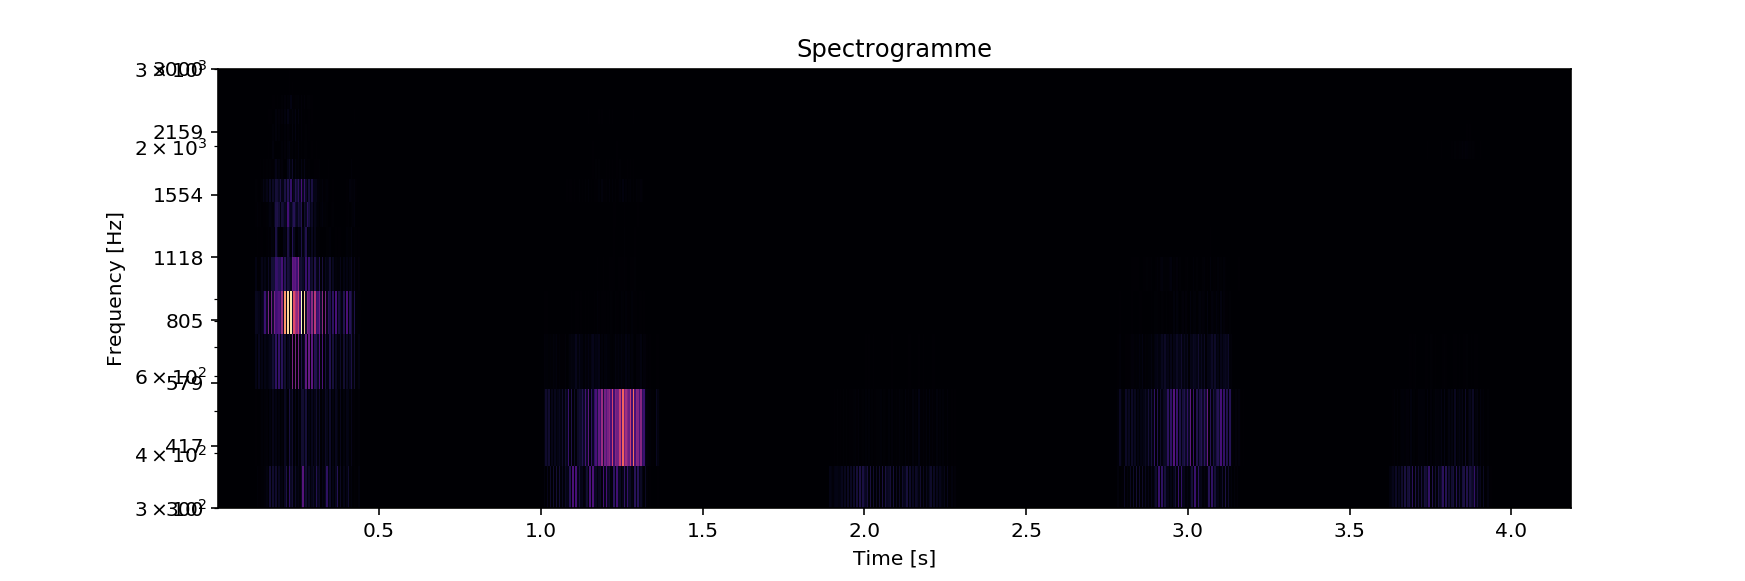

In [23]:
%run -i bin/plot_nspecgram.py
compute(file="src/demo.wav", fmin=300, fmax=5000, nb_filters=16, time_res=0.05, n=3, q=1, amp_res=4, spec_only=" ");
plot_nspecgram(file="src/demo.wav", filters_fq=filters_fq);

# > Traitement à la volée

Si **[pyaudio](https://people.csail.mit.edu/hubert/pyaudio/)** est installé sur votre machine, il est possible d'enregistrer des sons depuis votre microphone et de les traiter au fur et à mesure (avec un léger décalage).

Vous devez modifier le chemin ci-dessous pour qu'il corresponde au répertoire où se trouve **pyaudio**.

In [24]:
# Chemin vers les bibliothèques Python
lib_path = "C:\Program Files\Python36\Lib\site-packages"

In [25]:
%run -i bin/imports_pyaudio.py

La fonction [**live_record**](https://github.com/lowlighter/sound/blob/master/bin/live_record.py) permet de commencer à enregistrer le son provenant du microphone de votre ordinateur et de traiter les données à la volée.

Pour arrêter l'enregistrement, il faut **interrompre** le kernel.
![Interruption](src/imgs/stop.png)

In [26]:
%run -i bin/live_record.py
filters, filters_fq = gen_filters(fmin=100, fmax=4000, nb_filters=20, q=3, n=3, fs=12000)
live_record(time_res=0.1, amp_res=20, filters_fq=filters_fq, filters=filters, fs=12000, last=2, formants=[200, "a"])

Terminé !
